# Wavelet - AutoEncoder
## Initialisation and dataset preparation

First, let us import the required libraries.

https://www.youtube.com/watch?v=1CIpzeNxIhU&t=590s

In [184]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pywt
from misceallaneous import getWavFileAsNpArray, displaySpectrogram
from IPython.display import Audio
import librosa
import librosa.display
import keras.backend as K
from copy import deepcopy

Then, let us include the dataset.

The dataset is made from: `clean/p1.wav` on which random gaussian noise is added.

In [35]:
wavelet_family = "db38"

In [220]:
samplerate = 12000
nperseg = 1024

clean = np.array(getWavFileAsNpArray("../dataset_2/clean/p1.wav"), dtype="float32")
white = np.array(getWavFileAsNpArray("../dataset_2/white/p1.wav"), dtype="float32")

def get_wavelet_dataset(data=clean, samples_length=nperseg*2, noise_std=0.0):
    dataset = []
    for i in range(0, clean.shape[0]-samples_length, samples_length):
        dataset.append(data[i:i+samples_length])
    dataset = np.array(dataset)
    dataset += np.random.normal(0, noise_std*np.max(np.abs(dataset)), dataset.shape)
    wavelet_dataset = []
    for sample in dataset:
        ca, cd = pywt.dwt(sample, wavelet_family, "per")
        wavelet_dataset.append(np.concatenate((ca, cd)))
    max_data = np.max(np.abs(wavelet_dataset))*2
    return np.array(wavelet_dataset)/(max_data)

wavelet_clean_dataset = get_wavelet_dataset()
wavelet_white_dataset = get_wavelet_dataset(data = white)


In [221]:
def display_audio(data, g=None, p=0, i=0, save=True):
    audio = hear_audio(data, g, p, i)
    D = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, x_axis='time', y_axis='mel', sr=samplerate)
    if not save:
        plt.show()
    else:
        plt.savefig(str(p)+".png", format='png')
    
def get_ca_cd(data, g=None):
    if g == None:
        ca = data[:data_shape[0]]*max_clean
        cd = data[data_shape[0]:]*max_clean
    else:
        cacd = g.predict(np.reshape(data, (-1, data_shape[0]*2)))[0]
        ca = cacd[:data_shape[0]]*max_clean
        cd = cacd[data_shape[0]:]*max_clean
    return ca, cd

def get_audio(cacd):
    return pywt.idwt(cacd[0], cacd[1], wavelet_family, "per")

def hear_audio(data, g=None, p=0, i=0):
    ca, cd = get_ca_cd(data[i], g=g)
    audio = get_audio((ca, cd))
    return audio

def get_distance_audio(white, clean, g, i):
    return np.sum((get_audio(get_ca_cd(white[i], g)) - get_audio(get_ca_cd(clean[i])))**2)

def get_average_distance_audio(white, clean, g, n):
    res = 0
    for i in range(n):
        res += get_distance_audio(white, clean, g, i)
    return res/(n*100000000)

def get_distance_wavelets(white, clean, g, i):
    d = np.reshape(white[i], (-1, data_shape[0]*2))
    data = (g.predict(d))[0]
    return np.sum((data-clean[i])**2)

def get_average_distance_wavelets(white, clean, g, n):
    res = 0
    for i in range(n):
        res += get_distance_audio(white, clean, g, i)
    return res/n

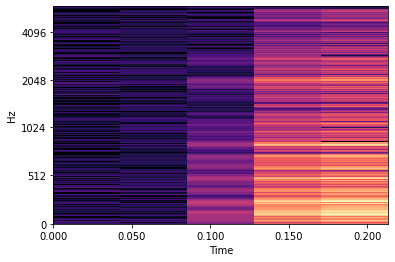

In [222]:
display_audio(get_wavelet_dataset(noise_std=0.0003), save=False)

In [223]:
def train_on_batch(d, i, o, validation_split=0, batch_size=16, epochs=1, verbose=True):
    history = d.fit(i, o, batch_size=batch_size, validation_split=validation_split, epochs=epochs, verbose=verbose)
    return np.mean(history.history['accuracy'])

In [224]:
def perceptual_loss(y_true, y_pred):
     return K.mean(K.square(y_true - y_pred))
    
def autoencoder(sizes):#, stddev):
    inputs = tf.keras.Input(shape=(sizes[1]))
    #x = tf.keras.layers.GaussianNoise(stddev)(inputs)
    x1 = tf.keras.layers.Dense(512, activation="tanh")(inputs)
    x2 = tf.keras.layers.Dense(128, activation="tanh")(x1)
    x3 = tf.keras.layers.Dense(512, activation="tanh")(x2)
    x4 = tf.keras.layers.Dense(sizes[1], activation="tanh")(x3)
    outputs = tf.keras.layers.Add()([inputs, x4])
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="autoencoder")
    model.summary()
    model.compile(optimizer='adam', loss=perceptual_loss, metrics=['accuracy'])
    return model

In [225]:
p = 0
mses_clean = []
mses_noisy = []
stddev_value = 0
#stddev = K.variable(value=stddev_value)
initial = autoencoder(wavelet_clean_dataset.shape)#, stddev=stddev)
wavelet_noised_dataset = get_wavelet_dataset(noise_std = stddev_value)
acc = 0
while acc < 0.95:
    acc = train_on_batch(initial, wavelet_noised_dataset, wavelet_clean_dataset)

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dense_216 (Dense)               (None, 512)          1049088     input_57[0][0]                   
__________________________________________________________________________________________________
dense_217 (Dense)               (None, 128)          65664       dense_216[0][0]                  
__________________________________________________________________________________________________
dense_218 (Dense)               (None, 512)          66048       dense_217[0][0]                  
________________________________________________________________________________________

In [228]:
trained_weights = initial.get_weights()

In [229]:
g = autoencoder(wavelet_clean_dataset.shape)
g.set_weights(trained_weights)

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dense_224 (Dense)               (None, 512)          1049088     input_59[0][0]                   
__________________________________________________________________________________________________
dense_225 (Dense)               (None, 128)          65664       dense_224[0][0]                  
__________________________________________________________________________________________________
dense_226 (Dense)               (None, 512)          66048       dense_225[0][0]                  
________________________________________________________________________________________

334/334 [==============================] - 3s 7ms/step - loss: 3.9072e-08 - accuracy: 0.9521
MSE clean: 639266.6 MSE noisy: 1275908100.0
334/334 [==============================] - 2s 7ms/step - loss: 3.9712e-08 - accuracy: 0.9506
MSE clean: 623279.3 MSE noisy: 1273226400.0
334/334 [==============================] - 3s 8ms/step - loss: 3.1412e-08 - accuracy: 0.9510
MSE clean: 252130.39 MSE noisy: 1272193500.0
334/334 [==============================] - 3s 8ms/step - loss: 2.8591e-08 - accuracy: 0.9501
MSE clean: 565401.94 MSE noisy: 1273034800.0
334/334 [==============================] - 3s 10ms/step - loss: 2.1390e-08 - accuracy: 0.9506
MSE clean: 357817.72 MSE noisy: 1270886300.0
334/334 [==============================] - 4s 12ms/step - loss: 1.8738e-08 - accuracy: 0.9508
MSE clean: 279464.34 MSE noisy: 1269638100.0
334/334 [==============================] - 3s 9ms/step - loss: 1.9935e-08 - accuracy: 0.9503
MSE clean: 270869.44 MSE noisy: 1270112800.0
185/334 [===============>.........

KeyboardInterrupt: 

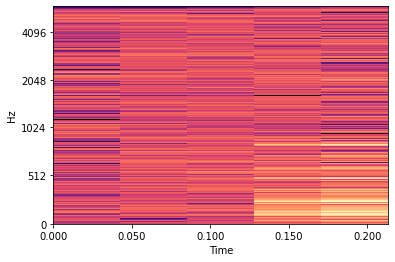

In [230]:
stddev_value = 0
steps = 10
p=0
for _ in range(steps):
    stddev_value += 0.00005
    wavelet_noised_dataset = get_wavelet_dataset(noise_std = stddev_value)
    acc = 0
    while acc < 0.95:
        acc = train_on_batch(g, wavelet_noised_dataset, wavelet_clean_dataset) 
    mse_clean = get_distance_audio(wavelet_clean_dataset, wavelet_clean_dataset, g, 100)
    mse_noisy = get_distance_audio(wavelet_white_dataset, wavelet_clean_dataset, g, 100)
    mses_clean.append(mse_clean)
    mses_noisy.append(mse_noisy)
    display_audio(wavelet_white_dataset, g=g, p=p)
    print("MSE clean:", mse_clean, "MSE noisy:", mse_noisy)
    p += 1
plt.plot(mses_clean)
plt.plot(mses_noisy)
plt.show()

## Audio testing

In [138]:
res = []
for i in range(10):
    res.append(hear_audio(wavelet_white_dataset, i=i))
audio = np.concatenate(res)
Audio(audio, rate=samplerate)

In [139]:
res = []
for i in range(10):
    res.append(hear_audio(wavelet_white_dataset, g=g, i=i))
audio = np.concatenate(res)
Audio(audio, rate=samplerate)